In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai torchaudio librosa


Preprocessing completed.


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.340668,2.155393,0.562500,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.289693,1.206375,0.625000,00:00
1,1.151535,0.899137,0.437500,00:00
2,1.234706,0.902424,0.500000,00:00
3,1.194878,0.919388,0.500000,00:00
4,1.164876,0.965193,0.437500,00:00
5,1.136704,1.043941,0.500000,00:00
6,1.111946,1.119545,0.562500,00:00
7,1.037770,1.231243,0.500000,00:00
8,0.963432,1.317193,0.437500,00:00
9,0.932688,1.358525,0.500000,00:00


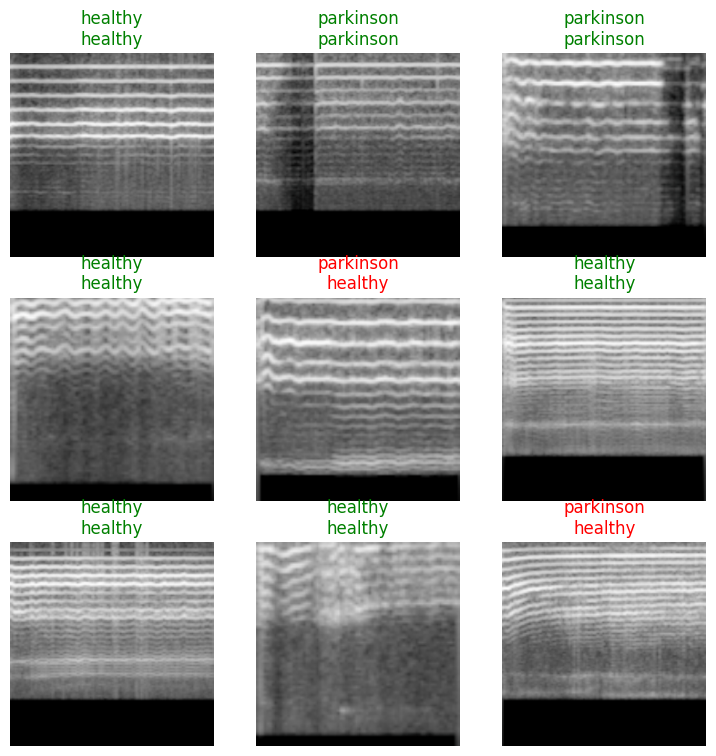

In [2]:
import os
from fastai.vision.all import *
import librosa
import numpy as np
from PIL import Image
import shutil

# Set the path to your dataset
path = Path('/kaggle/input/parkinsonandhealthyaudiodataset')
processed_path = Path('/kaggle/working/processed_spectrograms')

def get_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, duration=5)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def spec_to_image(spec):
    spec_normalized = (spec - spec.min()) / (spec.max() - spec.min())
    spec_rgb = np.repeat(spec_normalized[..., np.newaxis], 3, axis=-1)
    img = Image.fromarray(np.uint8(spec_rgb * 255))
    return img

def get_spec_image(audio_file):
    spec = get_spectrogram(audio_file)
    return spec_to_image(spec)

def preprocess_audio_files(input_path, output_path):
    if output_path.exists():
        shutil.rmtree(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    for class_folder in input_path.iterdir():
        if class_folder.is_dir():
            (output_path / class_folder.name).mkdir(exist_ok=True)
            for audio_file in class_folder.glob('*.wav'):
                img = get_spec_image(audio_file)
                img.save(output_path / class_folder.name / f"{audio_file.stem}.png")
    
    print("Preprocessing completed.")

# Preprocess audio files
preprocess_audio_files(path, processed_path)

# Create the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

# Create the DataLoaders
dls = dblock.dataloaders(processed_path, bs=32)

# Create and train the model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(50)

# Evaluate the model
learn.show_results()

In [95]:
# Function to make predictions
def predict_parkinsons(audio_file):
    img = get_spec_image(audio_file)
    pred, _, probs = learn.predict(img)
    return pred, probs

# Example usage
test_file = '/kaggle/input/parkinsonandhealthyaudiodataset/healthy/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav'
prediction, probabilities = predict_parkinsons(test_file)
print(f"Prediction: {prediction}")
print(f"Probabilities: {probabilities}")

Prediction: healthy
Probabilities: tensor([0.8867, 0.1133])


In [3]:
learn.export('predictor.pkl')